<a href="https://colab.research.google.com/github/JoKoum/satellite-image-classification/blob/main/satellite_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project in Deep Learning Class: Satellite Image Classification
---

### John Koumentis, Sotiris Panopoulos

The project evaluates the performance of the Attention mechanism over predicting the correct set of labels of the given satellite image.

The JPG version of the satellite images dataset [*Planet: Understanding the Amazon from Space*](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) was used. Those screenshots are chips extracted from the bigger dataset that are provided as a reference to the scene content.

In [1]:
!gdown https://drive.google.com/uc?id=19U9KgKaqbl2NntvQfcQrPXYMNR3ZzxuL
!tar -xvf "./train-jpg.tar" -C "./"

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
train-jpg/train_26915.jpg
train-jpg/train_18344.jpg
train-jpg/train_27704.jpg
train-jpg/train_7979.jpg
train-jpg/train_13032.jpg
train-jpg/train_35254.jpg
train-jpg/train_30338.jpg
train-jpg/train_27364.jpg
train-jpg/train_20550.jpg
train-jpg/train_15082.jpg
train-jpg/train_34316.jpg
train-jpg/train_35048.jpg
train-jpg/train_35424.jpg
train-jpg/train_5090.jpg
train-jpg/train_5713.jpg
train-jpg/train_39060.jpg
train-jpg/train_11864.jpg
train-jpg/train_36277.jpg
train-jpg/train_14203.jpg
train-jpg/train_12909.jpg
train-jpg/train_12433.jpg
train-jpg/train_37809.jpg
train-jpg/train_6081.jpg
train-jpg/train_32372.jpg
train-jpg/train_34065.jpg
train-jpg/train_2274.jpg
train-jpg/train_20986.jpg
train-jpg/train_3903.jpg
train-jpg/train_4412.jpg
train-jpg/train_21703.jpg
train-jpg/train_5448.jpg
train-jpg/train_20568.jpg
train-jpg/train_5143.jpg
train-jpg/train_3306.jpg
train-jpg/train_17657.jpg
train-jpg/train_22337.jpg
train-jpg/train_517

In [2]:
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import tensorflow as tf

### Dataset
---
The dataset that maps the image names with the respective tags (labels) is read and modified, so as to inlude each image's whole filepath in Colab notebook. Additionally, another column that includes the respective labels as list items is created. Using that column, we extracted the unique labels existing at the dataset, and plotted a respective image per label.

In [3]:
df = pd.read_csv('https://drive.google.com/uc?id=1MsAf8Iktmf1dC1pYQpJ-QjC3lOAg5J_3&export=download')
df.head(20)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [4]:
df['image_name'] = './train-jpg/' + df['image_name'] + '.jpg'

In [5]:
df['tags_split'] = df['tags'].apply(lambda x: x.split(' '))
labels_list = sum(list(df['tags_split'].values), [])
labels = set(labels_list)
labels

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

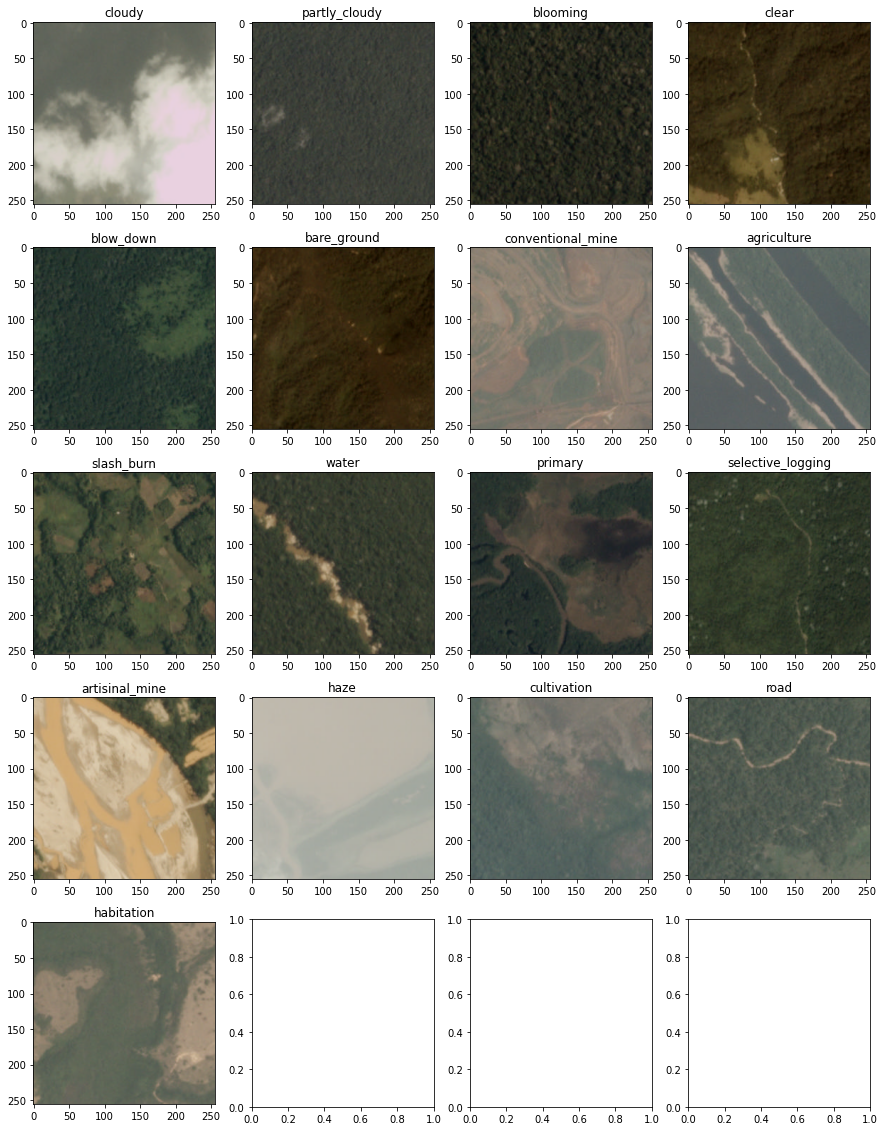

In [6]:
images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] for i, label in enumerate(labels)]

_, ax = plt.subplots(5,4, figsize=(15,20))
ax = ax.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels)):
  img = mpimg.imread(image_name)
  ax[i].imshow(img)
  ax[i].set_title('{}'.format(label))

Details on the labels are present at [Chip (Image) Data Format](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) section in Kaggle. 

## Image captioning approach
---
The [Image captioning with visual attention](https://www.tensorflow.org/tutorials/text/image_captioning) example was used as a base for the experiments that took place.

As first step, we create a dictionary that maps each image path with its labels. In order to create a text sequence representation of labels, that is going to be used later, the \<start\> and the \<end\> tokens have been added at the beginning and the end of each labels set.

In [7]:
image_path_to_label = collections.defaultdict(list)
for image_path, label in zip(df['image_name'],df['tags'].values):
  image_path_to_label[image_path].append(f"<start> {label} <end>")
print(len(image_path_to_label))
image_path_to_label

40479


defaultdict(list,
            {'./train-jpg/train_0.jpg': ['<start> haze primary <end>'],
             './train-jpg/train_1.jpg': ['<start> agriculture clear primary water <end>'],
             './train-jpg/train_2.jpg': ['<start> clear primary <end>'],
             './train-jpg/train_3.jpg': ['<start> clear primary <end>'],
             './train-jpg/train_4.jpg': ['<start> agriculture clear habitation primary road <end>'],
             './train-jpg/train_5.jpg': ['<start> haze primary water <end>'],
             './train-jpg/train_6.jpg': ['<start> agriculture clear cultivation primary water <end>'],
             './train-jpg/train_7.jpg': ['<start> haze primary <end>'],
             './train-jpg/train_8.jpg': ['<start> agriculture clear cultivation primary <end>'],
             './train-jpg/train_9.jpg': ['<start> agriculture clear cultivation primary road <end>'],
             './train-jpg/train_10.jpg': ['<start> agriculture clear primary slash_burn water <end>'],
             './t

In [8]:
image_paths = list(image_path_to_label.keys())
train_labels = []
img_name_vector = []

for image_path in image_paths:
  label_list = image_path_to_label[image_path]
  train_labels.extend(label_list)
  img_name_vector.extend([image_path]*len(label_list))

print(len(img_name_vector))
img_name_vector[1:20]

40479


['./train-jpg/train_1.jpg',
 './train-jpg/train_2.jpg',
 './train-jpg/train_3.jpg',
 './train-jpg/train_4.jpg',
 './train-jpg/train_5.jpg',
 './train-jpg/train_6.jpg',
 './train-jpg/train_7.jpg',
 './train-jpg/train_8.jpg',
 './train-jpg/train_9.jpg',
 './train-jpg/train_10.jpg',
 './train-jpg/train_11.jpg',
 './train-jpg/train_12.jpg',
 './train-jpg/train_13.jpg',
 './train-jpg/train_14.jpg',
 './train-jpg/train_15.jpg',
 './train-jpg/train_16.jpg',
 './train-jpg/train_17.jpg',
 './train-jpg/train_18.jpg',
 './train-jpg/train_19.jpg']

### Feature Extractor
---
A pre-trained Convolutional Neural Network was used, as feature extractor. The output of the last convolutional layer with shape (7, 7, 2048) will be used as the input feature for the Attention mechanism. ResNet50_V2 was chosen as Residual Networks are a state-of-the-art Convolutional Neural Network category that has been also used as feature extractor in similar tasks like the ["Recurrent neural networks for remote sensing image classification"](https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/iet-cvi.2017.0420) and ["Self-attention for raw optical Satellite Time Series Classification"](https://arxiv.org/pdf/1910.10536.pdf).

In [9]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

new_input = base_model.input
hidden_layer = base_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

94674944/94668760 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____________________________

### Image Preprocessing
---
We preprocess the images using the preprocess_input method to normalize the image so that it contains pixels with values in the range [-1, 1], which matches the format of the images used to train ResNet50_V2.


In [10]:
def load_image(image_path):
    """
    Input: Image path
    Output: Procesed image tensor, Image path
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

Image features are extracted and cached ((7 * 7 * 2048) floats per image) in NumPy binary file format, to be used during the netwoks training procedure.

In [11]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
  
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 2530/2530 [07:04<00:00,  5.97it/s]


### Tokenize labels
---
Using the TensorFlow Tokenizer method, labels are tokenized by getting split on spaces. Word to index and index to word mapping is created and finally, padding is applied, so as each created sequence to have the same length as the longest one.

In [12]:
def calc_max_length(tensor):
  """
  Calculate max length of any labelset in the dataset
  """
  return max(len(t) for t in tensor)

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(set(train_labels)),
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~')
tokenizer.fit_on_texts(train_labels)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_sequences = tokenizer.texts_to_sequences(train_labels)

In [14]:
tokenizer.word_index

{'<end>': 2,
 '<pad>': 0,
 '<start>': 1,
 'agriculture': 5,
 'artisinal_mine': 15,
 'bare_ground': 13,
 'blooming': 16,
 'blow_down': 18,
 'clear': 4,
 'cloudy': 12,
 'conventional_mine': 19,
 'cultivation': 9,
 'habitation': 10,
 'haze': 11,
 'partly_cloudy': 8,
 'primary': 3,
 'road': 6,
 'selective_logging': 14,
 'slash_burn': 17,
 'water': 7}

In [15]:
# Pad each vector to the max_length of the labels
label_vector = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post')
print('Labels vector:\n', label_vector)

Labels vector:
 [[ 1 11  3 ...  0  0  0]
 [ 1  5  4 ...  0  0  0]
 [ 1  4  3 ...  0  0  0]
 ...
 [ 1  5  4 ...  0  0  0]
 [ 1  5  4 ...  0  0  0]
 [ 1  5  9 ...  0  0  0]]


In [16]:
max_length = calc_max_length(train_sequences)
print('Max sequence length: ',max_length)

Max sequence length:  11


### Split to train and test
---
Dataset is split into training and validation sets, 80% and 20% of the examples, respectively.

In [17]:
img_to_label_vector = collections.defaultdict(list)

for image, label in zip(img_name_vector, label_vector):
  img_to_label_vector[image].append(label)

img_keys = list(img_to_label_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) *  0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
label_train = []

for imgt in img_name_train_keys:
  label_len = len(img_to_label_vector[imgt])
  img_name_train.extend([imgt] * label_len)
  label_train.extend(img_to_label_vector[imgt])

img_name_val = []
label_val = []

for imgt in img_name_val_keys:
  label_len = len(img_to_label_vector[imgt])
  img_name_val.extend([imgt] * label_len)
  label_val.extend(img_to_label_vector[imgt])

In [18]:
len(img_name_train), len(label_train), len(img_name_val), len(label_val)

(32383, 32383, 8096, 8096)

### Create Dataset for training 

Two datasets are created, one for the train and one for the validation set, using the TensorFlow Dataset module. Moreover, network hyperparameters are set up. 

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size =  len(set(train_labels)) + 1
num_steps = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
# These two variables represent the feature vector shape
features_shape = 2048
attention_features_shape = 49

In [20]:
def map_func(img_name, label):
  """
  Load previously stored numpy files
  """
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, label

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, label_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
val_set = tf.data.Dataset.from_tensor_slices((img_name_val, label_val))

# Use map to load the numpy files in parallel
val_set = val_set.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

val_set = val_set.batch(BATCH_SIZE)
val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model

In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

Initialize encoder and decoder networks

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

Initializing Adam optimizer and selecting Sparse Categorical Cross Entropy loss function.

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [28]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [29]:
# Create checkpoint to store trained model parameters for future use
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [31]:
# List to keep the recorded training loss
train_loss_plot = []
val_loss_plot = []

In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the labels are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<pad>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [33]:
def validation_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<pad>']] * target.shape[0], 1)

  features = encoder(img_tensor)
  
  for i in range(1, target.shape[1]):
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    loss += loss_function(target[:, i], predictions)
    dec_input = tf.expand_dims(target[:, i], 1)
  
  total_loss = (loss / int(target.shape[1]))
  
  return loss, total_loss

In [34]:
EPOCHS = 10

val_loss_min = np.Inf

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    val_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    train_loss_plot.append(total_loss / num_steps)

    for (batch, (img_tensor,target)) in enumerate(val_set):

      batch_loss, v_loss = validation_step(img_tensor, target)
      val_loss += v_loss
        
    val_loss_plot.append(val_loss/num_steps_val)

    if val_loss < val_loss_min:
      ckpt_manager.save()
      val_loss_min = val_loss
      print('Validation loss decreased, saving model')

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Validation loss {val_loss/num_steps_val:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.2620
Epoch 1 Batch 100 Loss 0.3603
Epoch 1 Batch 200 Loss 0.3411
Epoch 1 Batch 300 Loss 0.3042
Epoch 1 Batch 400 Loss 0.3007
Epoch 1 Batch 500 Loss 0.3509
Validation loss decreased, saving model
Epoch 1 Loss 0.349228
Validation loss 0.310315
Time taken for 1 epoch 554.68 sec

Epoch 2 Batch 0 Loss 0.3114
Epoch 2 Batch 100 Loss 0.3289
Epoch 2 Batch 200 Loss 0.3236
Epoch 2 Batch 300 Loss 0.2947
Epoch 2 Batch 400 Loss 0.3065
Epoch 2 Batch 500 Loss 0.3157
Validation loss decreased, saving model
Epoch 2 Loss 0.301402
Validation loss 0.298529
Time taken for 1 epoch 506.06 sec

Epoch 3 Batch 0 Loss 0.3241
Epoch 3 Batch 100 Loss 0.2935
Epoch 3 Batch 200 Loss 0.2987
Epoch 3 Batch 300 Loss 0.2886
Epoch 3 Batch 400 Loss 0.2938
Epoch 3 Batch 500 Loss 0.2762
Epoch 3 Loss 0.298747
Validation loss 0.300190
Time taken for 1 epoch 567.40 sec

Epoch 4 Batch 0 Loss 0.3144
Epoch 4 Batch 100 Loss 0.3267
Epoch 4 Batch 200 Loss 0.3023
Epoch 4 Batch 300 Loss 0.2715
Epoch 4 Batch 400 Loss

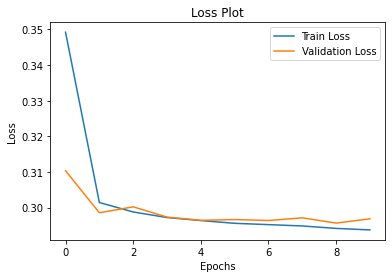

In [35]:
plt.plot(train_loss_plot, label='Train Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [37]:
def plot_attention(image, result, attention_plot):
    image = Image.open(image)
    
    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [38]:
def test_image(img_id):
  # Labels on the validation set
  image = img_name_val[img_id]
  real_caption = ' '.join([tokenizer.index_word[i] for i in label_val[img_id] if i not in [0]])
  result, attention_plot = evaluate(image)

  actual_image = Image.open(image)
  plt.imshow(actual_image)
    
  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)

In [39]:
# Restore networks at their latest saved state
ckpt.restore(ckpt_manager.latest_checkpoint)

Real Caption: <start> partly_cloudy primary water <end>
Prediction Caption: <end>


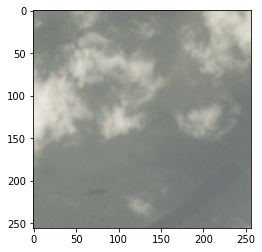

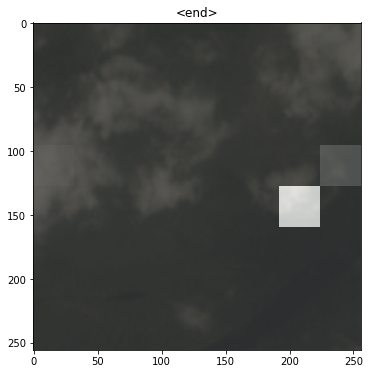

In [50]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> agriculture clear primary road water <end>
Prediction Caption: water <end>


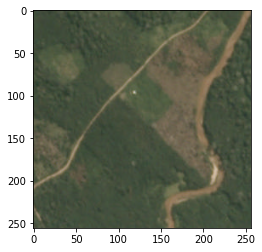

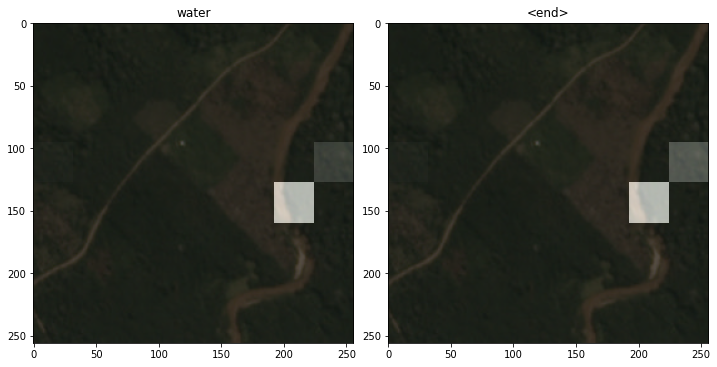

In [53]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: agriculture clear primary road <end>


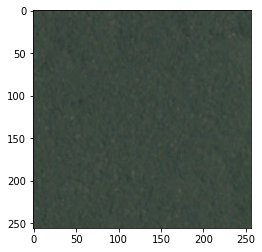

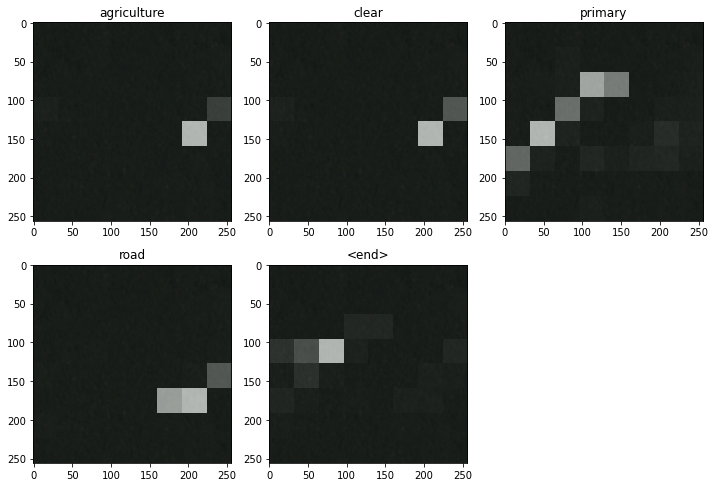

In [49]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

### Conclusions
---